# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

D:\python\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

In [14]:
final['Score'].value_counts()

1    293516
0     54744
Name: Score, dtype: int64

In [15]:
pos_reviews=final[final['Score']== 1].sample(n=50000)
neg_reviews=final[final['Score']== 0].sample(n=50000)
a=(pos_reviews,neg_reviews)
final=pd.concat(a)

# FEATURE ENGINEERING

In [16]:
#Concating both the summary and text inorder to improve the model and then using it to test the model

#https://stackoverflow.com/questions/19377969/combine-two-columns-of-text-in-dataframe-in-pandas-python

final['TEXT_SUMMARY']=final['Text'] +" "+ final["Summary"]

final=final.sort_values(by='Time')



final['TEXT_SUMMARY'][:1]==(final['Text'][:1]+" "+final['Summary'][:1])


346041    True
dtype: bool

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 =final['TEXT_SUMMARY'].values[0]


sent_1000 =final['TEXT_SUMMARY'].values[1000]


sent_1500 =final['TEXT_SUMMARY'].values[1500]


sent_4900 =final['TEXT_SUMMARY'].values[4900]


# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()


soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()


soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()


soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()

# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

sent_1500 = decontracted(sent_1500)


#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()


#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)


# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

I, myself always enjoyed this movie, it's very funny and entertaining, so I didn't hesitate to pick up the clamshell edition.  I guess it was a marketing plan to make the movie more for families or something, but they  have eliminated all strong profanity and elements that are usually edited  in the television version.  YOU HAVE BEEN WARNED.  If you want the uncut  version, AVOID THE CLAMSHELL EDITION! WARNING: CLAMSHELL EDITION IS EDITED TV VERSION


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:14<00:00, 1344.80it/s]


In [18]:
preprocessed_reviews[1500]

'course prefer freshly made espresso sometimes instant good pinch travel around europe extensively several brands available not bad brand ok using coffee flavoring custards etc beverage rates rock bottom book'

In [19]:
import pickle
with open("final['Score'].pkl",'wb') as f:
    pickle.dump(final['Score'],f)

with open("preprocessed_reviews.pkl",'wb') as f:
    pickle.dump(preprocessed_reviews,f)


# [4] Featurization

In [20]:
len(preprocessed_reviews)

100000

In [21]:
len(final['Score'])

100000

In [22]:
# SPLITTING THE DATA INTO TEST TRAIN AND CV

y_train= final['Score'][:60000]
y_cv=    final['Score'][60000:80000]
y_test=  final['Score'][80000:100000]

x_train= preprocessed_reviews[:60000]
x_cv=    preprocessed_reviews[60000:80000]
x_test=  preprocessed_reviews[80000:100000]



## [4.1] BAG OF WORDS

In [23]:
print("VECTOR OF THE TEXT AND SUMMARY")
print("-------------------------------------------")
#train_BoW

count_vect = CountVectorizer() #in scikit-learn
train_bow  = count_vect.fit_transform(x_train )
print("the type of count vectorizer ",type(train_bow ))
print("the shape of out text BOW vectorizer ",train_bow .get_shape())
print("the number of unique words ", train_bow .get_shape()[1])
print("********************************************")
#cv_BoW
cv_bow  = count_vect.transform(x_cv )
print("the type of count vectorizer ",type(cv_bow ))
print("the shape of out text BOW vectorizer ",cv_bow .get_shape())
print("the number of unique words ", cv_bow .get_shape()[1])
#cv_BoW
#cv_BoW
test_bow  = count_vect.transform(x_test )
print("the type of count vectorizer ",type(test_bow ))
print("the shape of out text BOW vectorizer ",test_bow .get_shape())
print("the number of unique words ", test_bow .get_shape()[1])


VECTOR OF THE TEXT AND SUMMARY
-------------------------------------------
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 47607)
the number of unique words  47607
********************************************
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 47607)
the number of unique words  47607
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 47607)
the number of unique words  47607




## [4.2] Bi-Grams and n-Grams.

In [24]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (100000, 500)
the number of unique words including both unigrams and bigrams  500


## [4.3] TF-IDF

In [25]:
print("VECTOR OF TEXT AND SUMMARY")
print("                                  ")
#tfidf_train
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)
train_tf_idf = tf_idf_vect.fit_transform(x_train)
print("the type of count vectorizer ",type(train_tf_idf))
print("the shape of out text TFIDF vectorizer ",train_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", train_tf_idf.get_shape()[1])
# tfidf_test
test_tf_idf = tf_idf_vect.transform(x_test)
print("the type of count vectorizer ",type(test_tf_idf))
print("the shape of out text TFIDF vectorizer ",test_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", test_tf_idf.get_shape()[1])

# tdidf_cv
cv_tf_idf = tf_idf_vect.transform(x_cv)
print("the type of count vectorizer ",type(cv_tf_idf))
print("the shape of out text TFIDF vectorizer ",cv_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", cv_tf_idf.get_shape()[1])

VECTOR OF TEXT AND SUMMARY
                                  
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (60000, 500)
the number of unique words including both unigrams and bigrams  500
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (20000, 500)
the number of unique words including both unigrams and bigrams  500
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (20000, 500)
the number of unique words including both unigrams and bigrams  500


## [4.3] AVG Word2Vec

In [31]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())

w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    

list=[]
w2v_words_dict = (w2v_model.wv.vocab)
w2v_words=w2v_words_dict.keys()
list=[]
print("number of words that occured minimum 5 times ",len(w2v_words))
for i in w2v_words:
    list.append(i)
print("sample words ", list[0:50])


# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train= []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

## [4.4] Word2Vec

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in x_cv:
    list_of_sentance.append(sentance.split())

list=[]
w2v_words_dict = (w2v_model.wv.vocab)
w2v_words=w2v_words_dict.keys()
list=[]
print("number of words that occured minimum 5 times ",len(w2v_words))
for i in w2v_words:
    list.append(i)
print("sample words ", list[0:50])


# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

## [4.4] Word2Vec

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in x_test:
    list_of_sentance.append(sentance.split())
                            

list=[]
w2v_words_dict = (w2v_model.wv.vocab)
w2v_words=w2v_words_dict.keys()
list=[]
print("number of words that occured minimum 5 times ",len(w2v_words))
for i in w2v_words:
    list.append(i)
print("sample words ", list[0:50])


# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

number of words that occured minimum 5 times  15358
sample words  ['little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'beetlejuice', 'well', 'written', 'movie', 'everything', 'excellent', 'acting', 'special', 'effects', 'delighted', 'chose', 'view', 'enjoyed', 'funny', 'entertaining', 'not', 'hesitate', 'pick', 'edition', 'guess', 'marketing', 'plan', 'make', 'families', 'something']


100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:17<00:00, 3502.66it/s]


60000
50
number of words that occured minimum 5 times  15358
sample words  ['little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'beetlejuice', 'well', 'written', 'movie', 'everything', 'excellent', 'acting', 'special', 'effects', 'delighted', 'chose', 'view', 'enjoyed', 'funny', 'entertaining', 'not', 'hesitate', 'pick', 'edition', 'guess', 'marketing', 'plan', 'make', 'families', 'something']


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:05<00:00, 3408.43it/s]


20000
50
number of words that occured minimum 5 times  15358
sample words  ['little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'beetlejuice', 'well', 'written', 'movie', 'everything', 'excellent', 'acting', 'special', 'effects', 'delighted', 'chose', 'view', 'enjoyed', 'funny', 'entertaining', 'not', 'hesitate', 'pick', 'edition', 'guess', 'marketing', 'plan', 'make', 'families', 'something']


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:05<00:00, 3370.63it/s]


20000
50


## TFIDF-W2V

In [32]:
## [4.4] Word2Vec

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())
                            

list=[]
w2v_words_dict = (w2v_model.wv.vocab)
w2v_words=w2v_words_dict.keys()
list=[]
print("number of words that occured minimum 5 times ",len(w2v_words))
for i in w2v_words:
    list.append(i)
print("sample words ", list[0:50])


# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
list=[]
for i in model.idf_:
    list.append(i)
dictionary = dict(zip(model.get_feature_names(), list))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

## [4.4] Word2Vec

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in x_cv:
    list_of_sentance.append(sentance.split())
                            

list=[]
w2v_words_dict = (w2v_model.wv.vocab)
w2v_words=w2v_words_dict.keys()
list=[]
print("number of words that occured minimum 5 times ",len(w2v_words))
for i in w2v_words:
    list.append(i)
print("sample words ", list[0:50])


# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_cv)
# we are converting a dictionary with word as a key, and the idf as a value
list=[]
for i in model.idf_:
    list.append(i)
dictionary = dict(zip(model.get_feature_names(), list))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

## [4.4] Word2Vec

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in x_test:
    list_of_sentance.append(sentance.split())
                            

list=[]
w2v_words_dict = (w2v_model.wv.vocab)
w2v_words=w2v_words_dict.keys()
list=[]
print("number of words that occured minimum 5 times ",len(w2v_words))
for i in w2v_words:
    list.append(i)
print("sample words ", list[0:50])


# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_test)
# we are converting a dictionary with word as a key, and the idf as a value
list=[]
for i in model.idf_:
    list.append(i)
dictionary = dict(zip(model.get_feature_names(), list))

# TF-IDF weighted Word2Vec
Tfidf_feat = model.get_feature_names() # Tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = Tfidf

Tfidf_sent_vectors_test = []; # the Tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in Tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, Tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    Tfidf_sent_vectors_test.append(sent_vec)
    row += 1

number of words that occured minimum 5 times  15358
sample words  ['little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'beetlejuice', 'well', 'written', 'movie', 'everything', 'excellent', 'acting', 'special', 'effects', 'delighted', 'chose', 'view', 'enjoyed', 'funny', 'entertaining', 'not', 'hesitate', 'pick', 'edition', 'guess', 'marketing', 'plan', 'make', 'families', 'something']


100%|████████████████████████████████████████████████████████████████████████████| 60000/60000 [59:48<00:00, 16.72it/s]


number of words that occured minimum 5 times  15358
sample words  ['little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'beetlejuice', 'well', 'written', 'movie', 'everything', 'excellent', 'acting', 'special', 'effects', 'delighted', 'chose', 'view', 'enjoyed', 'funny', 'entertaining', 'not', 'hesitate', 'pick', 'edition', 'guess', 'marketing', 'plan', 'make', 'families', 'something']


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:43<00:00, 58.21it/s]


number of words that occured minimum 5 times  15358
sample words  ['little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'beetlejuice', 'well', 'written', 'movie', 'everything', 'excellent', 'acting', 'special', 'effects', 'delighted', 'chose', 'view', 'enjoyed', 'funny', 'entertaining', 'not', 'hesitate', 'pick', 'edition', 'guess', 'marketing', 'plan', 'make', 'families', 'something']


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:45<00:00, 57.89it/s]


In [33]:
from sklearn.preprocessing import StandardScaler 
scaler= StandardScaler(with_mean=False)
train_bow = scaler.fit_transform (train_bow)
cv_bow=scaler.transform(cv_bow)
test_bow=scaler.transform(test_bow)

D:\python\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\python\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\python\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\python\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [34]:
scaler= StandardScaler(with_mean=False)
train_tf_idf = scaler.fit_transform(train_tf_idf)
cv_tf_idf=scaler.transform(cv_tf_idf)
test_tf_idf=scaler.transform(test_tf_idf)

In [35]:
scaler= StandardScaler()
sent_vectors_train = scaler.fit_transform(sent_vectors_train)
sent_vectors_cv=scaler.transform(sent_vectors_cv)
sent_vectors_test=scaler.transform(sent_vectors_test)

In [36]:
scaler= StandardScaler()

tfidf_sent_vectors_cv=scaler.fit_transform(tfidf_sent_vectors_cv)
tfidf_sent_vectors_test=scaler.transform(Tfidf_sent_vectors_test)
tfidf_sent_vectors_train=scaler.transform(tfidf_sent_vectors_train)

# Applying Decision Trees

In [26]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import roc_auc_score

def SimpleCrossValidation_min(x_train,x_cv,pred_train_data,pred_cv_data,x_test):
    print("AFTER FEATURE ENGINEERING")
    list_train=[]
    list_cv=[]
    min=[5,10,100,500]
    for i in min:
        
     
        clf=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=1000,
             max_leaf_nodes=1000,
            min_impurity_split=None, min_samples_leaf=100,
            min_samples_split=i, 
            splitter='best')
        # fitting the model on crossvalidation traincc
        clf.fit(x_train, y_train)
         
         
        predicted_train=[]
        pred_train=[]
        predicted_cv=[]
        pred_cv=[]
        # predict the response on the train 
       
        for j in range(0,60000,1000):
                predicted_train =clf.predict_proba(pred_train_data[j:(j+1000)])
                pred_train.extend(predicted_train[:,1])

        # predict the response on the crossvalidation 
        
        for j in range(0,20000,1000):
                predicted_cv =clf.predict_proba(pred_cv_data[j:(j+1000)])
                pred_cv.extend(predicted_cv[:,1])
        
        # evaluate train accuracy
        auc_train=roc_auc_score(y_train,pred_train)
        #print('AUC train SCORE  FOR', alpha ,'is', auc_train*100)
        list_train.append(auc_train)
    
     
        # evaluate cv accuracy
        auc_cv=roc_auc_score(y_cv,pred_cv)  
        print('AUC cv SCORE  FOR', i ,'is', auc_cv*100)
        list_cv.append(auc_cv)
        list_cv_max=max(list_cv)

    print("="*50)
    print("train AUC SCORE",list_train)
    pred_train=pred_train
    print("="*50)
    print(" MAX CV AUC SCORE",list_cv_max*100)
    pred_cv=pred_cv
    
    return list_train,list_cv,pred_train,pred_cv,min,clf
        

In [27]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import roc_auc_score

def SimpleCrossValidation_depth(x_train,x_cv,pred_train_data,pred_cv_data,x_test):
    print("AFTER FEATURE ENGINEERING")
    list_train=[]
    list_cv=[]
    depth=[1,5,10,50,100,500,1000]
    for i in depth:
        
     
        clf=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=i,
             max_leaf_nodes=1000,
            min_impurity_split=None, min_samples_leaf=100,
            min_samples_split=10, 
            splitter='best')
        # fitting the model on crossvalidation traincc
        clf.fit(x_train, y_train)
         
         
        predicted_train=[]
        pred_train=[]
        predicted_cv=[]
        pred_cv=[]
        # predict the response on the train 
       
        for j in range(0,60000,1000):
                predicted_train =clf.predict_proba(pred_train_data[j:(j+1000)])
                pred_train.extend(predicted_train[:,1])

        # predict the response on the crossvalidation 
        
        for j in range(0,20000,1000):
                predicted_cv =clf.predict_proba(pred_cv_data[j:(j+1000)])
                pred_cv.extend(predicted_cv[:,1])
        
        # evaluate train accuracy
        auc_train=roc_auc_score(y_train,pred_train)
        #print('AUC train SCORE  FOR', alpha ,'is', auc_train*100)
        list_train.append(auc_train)
    
     
        # evaluate cv accuracy
        auc_cv=roc_auc_score(y_cv,pred_cv)  
        print('AUC cv SCORE  FOR', i ,'is', auc_cv*100)
        list_cv.append(auc_cv)
        list_cv_max=max(list_cv)

    print("="*50)
    print("train AUC SCORE",list_train)
    pred_train=pred_train
    print("="*50)
    print(" MAX CV AUC SCORE",list_cv_max*100)
    pred_cv=pred_cv
    
    return list_train,list_cv,pred_train,pred_cv,depth,clf
        

In [28]:
def AUCcurve_min(y1,y2):
    
    x=[5,10,100,500]
    plt.xlabel('hyperparameter')
    plt.ylabel('AREA UNDER GRAPH')
    plt.title("auc of train and cv data")
    plt.plot(x,y1,'y', label='train')
    plt.plot(x,y2, 'r',label='cv' )
    plt.legend()
    plt.show()

In [29]:
def AUCcurve_depth(y1,y2):
    
    x=[1,5,10,50,100,500,1000]
    plt.xlabel('hyperparameter')
    plt.ylabel('AREA UNDER GRAPH')
    plt.title("auc of train and cv data")
    plt.plot(x,y1,'y', label='train')
    plt.plot(x,y2, 'r',label='cv' )
    plt.legend()
    plt.show()

In [30]:
# ROC FOR TRAIN AND TEST TFIDF
def ROC_curve(pred_train,pred_test):
    plt.title('Receiver Operating Characteristic  after feature engineering')
    fbr_train,tpr_train,thresholds=metrics.roc_curve(y_train,pred_train)
    roc_auc=metrics.auc(fbr_train,tpr_train)
    fbr_test,tpr_test,thresholds=metrics.roc_curve(y_test,pred_test)
    roc_auc=metrics.auc(fbr_test,tpr_test)
    plt.plot(fbr_test,tpr_test,'b',label="roc_auc of test")
    plt.legend()
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.plot(fbr_train,tpr_train,'r',label="roc_auc of train")
    plt.legend(loc='lower right')
    plt.show()


In [31]:
# CONFUSION MATRIX FOR TFIDF
def confusion(pred_test):
    confusion_tf_idf2=confusion_matrix(y_test,pred_test)
    plt.figure(figsize=[8,6])
    sns.heatmap(confusion_tf_idf2,annot=True,annot_kws={'size':16},fmt='g')
    plt.title("confusion matrix for tf_idf after feature engineering")
    plt.xlabel("Predicted values")
    plt.ylabel("Actual Value")
    plt.show()

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [32]:
list_train,list_cv,pred_train,pred_cv,depth,clf=SimpleCrossValidation_depth(x_test=test_bow,x_train=train_bow,x_cv=cv_bow,pred_train_data=train_bow,pred_cv_data=cv_bow)

AFTER FEATURE ENGINEERING
AUC cv SCORE  FOR 1 is 67.24915220553336
AUC cv SCORE  FOR 5 is 75.09147237552973
AUC cv SCORE  FOR 10 is 79.69644086302318
AUC cv SCORE  FOR 50 is 83.0193386806736
AUC cv SCORE  FOR 100 is 83.0193386806736
AUC cv SCORE  FOR 500 is 83.0193386806736
AUC cv SCORE  FOR 1000 is 83.0193386806736
train AUC SCORE [0.6722913790993683, 0.7531308035613381, 0.7989788665941229, 0.8370494362075755, 0.8370494362075755, 0.8370494362075755, 0.8370494362075755]
 MAX CV AUC SCORE 83.0193386806736


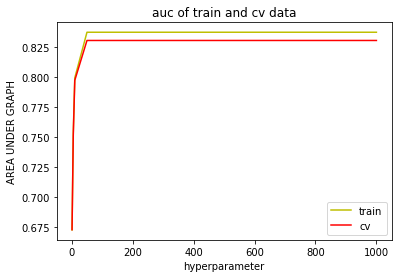

In [33]:
AUCcurve_depth(y1=list_train,y2=list_cv)

In [34]:
list_train,list_cv,pred_train,pred_cv,clf,min=SimpleCrossValidation_min(x_test=test_bow,x_train=train_bow,x_cv=cv_bow,pred_train_data=train_bow,pred_cv_data=cv_bow)

AFTER FEATURE ENGINEERING
AUC cv SCORE  FOR 5 is 83.0193386806736
AUC cv SCORE  FOR 10 is 83.0193386806736
AUC cv SCORE  FOR 100 is 83.0193386806736
AUC cv SCORE  FOR 500 is 82.87329710136615
train AUC SCORE [0.8370494362075755, 0.8370494362075755, 0.8370494362075755, 0.8341828809436034]
 MAX CV AUC SCORE 83.0193386806736


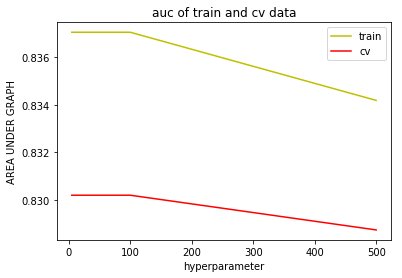

In [35]:
AUCcurve_min(y1=list_train,y2=list_cv)

In [36]:

clf=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=1000,
             max_leaf_nodes=1000,
            min_impurity_split=None, min_samples_leaf=100,
            min_samples_split=10, 
            splitter='best')

clf.fit(train_bow, y_train)
pred_test_bow= (clf.predict_proba(test_bow))[:,1]
auc_test=roc_auc_score(y_test,pred_test_bow)*100
print('AUC VALUE FOR TEST DATA',auc_test)
pred_test=clf.predict(test_bow)

AUC VALUE FOR TEST DATA 82.55141656970476


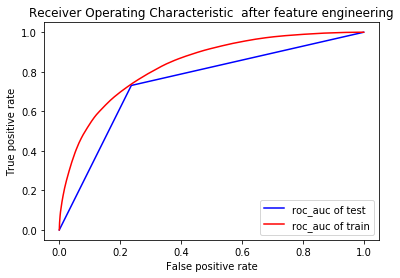

In [37]:
ROC_curve(pred_train,pred_test)

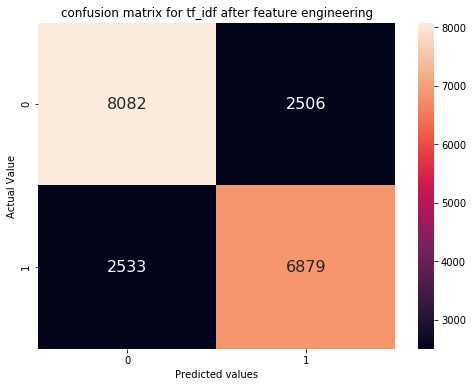

In [38]:
confusion(pred_test)

# [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [60]:
w=clf.feature_importances_
feature_names=count_vect.get_feature_names()
top_class=sorted(zip(w,feature_names),reverse=True)[:20]
top_class

[(0.43821955570688104, 'not even'),
 (0.35144764992287564, 'grocery'),
 (0.10305271605859449, 'best'),
 (0.07572157037475546, 'dogs'),
 (0.02365381881220099, 'thought'),
 (0.00790468912469248, 'unfortunately'),
 (0.0, 'yet'),
 (0.0, 'yes'),
 (0.0, 'years'),
 (0.0, 'year'),
 (0.0, 'wrong'),
 (0.0, 'would not'),
 (0.0, 'would'),
 (0.0, 'worth'),
 (0.0, 'worst'),
 (0.0, 'works'),
 (0.0, 'work'),
 (0.0, 'wonderful'),
 (0.0, 'without'),
 (0.0, 'wish')]

In [56]:
top_class

[(0.43821955570688104, 'not even'),
 (0.35144764992287564, 'grocery'),
 (0.10305271605859449, 'best'),
 (0.07572157037475546, 'dogs'),
 (0.02365381881220099, 'thought'),
 (0.00790468912469248, 'unfortunately'),
 (0.0, 'yet'),
 (0.0, 'yes'),
 (0.0, 'years'),
 (0.0, 'year'),
 (0.0, 'wrong'),
 (0.0, 'would not'),
 (0.0, 'would'),
 (0.0, 'worth'),
 (0.0, 'worst'),
 (0.0, 'works'),
 (0.0, 'work'),
 (0.0, 'wonderful'),
 (0.0, 'without'),
 (0.0, 'wish')]

# [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

In [41]:
import graphviz 
from sklearn import tree
clf=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3)
clf.fit(train_bow, y_train)

dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 

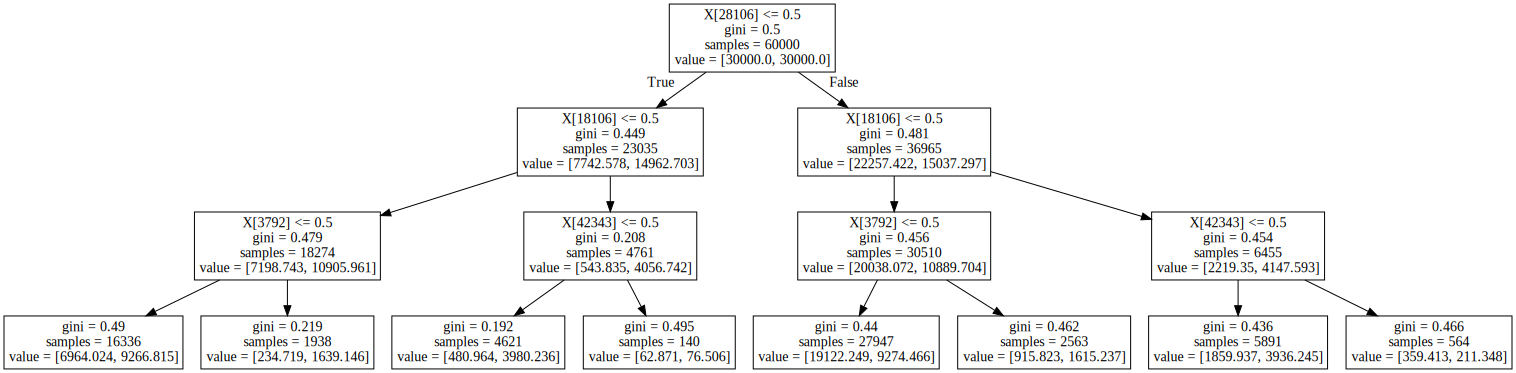

In [42]:
graph

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [43]:
list_train,list_cv,pred_train,pred_cv,depth,clf=SimpleCrossValidation_depth(x_train=train_tf_idf,x_cv=cv_tf_idf,pred_train_data=train_tf_idf,pred_cv_data=cv_tf_idf,x_test=test_tf_idf)


AFTER FEATURE ENGINEERING
AUC cv SCORE  FOR 1 is 67.4142221478474
AUC cv SCORE  FOR 5 is 75.37385370513178
AUC cv SCORE  FOR 10 is 79.6513511284749
AUC cv SCORE  FOR 50 is 83.38481113242948
AUC cv SCORE  FOR 100 is 83.38666698139127
AUC cv SCORE  FOR 500 is 83.38666698139127
AUC cv SCORE  FOR 1000 is 83.39514784390094
train AUC SCORE [0.6734482411152769, 0.7558987286932047, 0.8039599816550761, 0.8516297097803184, 0.851820279981664, 0.851820279981664, 0.8518432183739623]
 MAX CV AUC SCORE 83.39514784390094


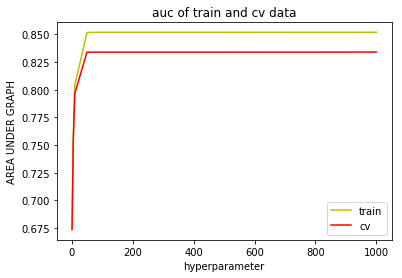

In [44]:
AUCcurve_depth(y1=list_train,y2=list_cv)

In [45]:
list_train,list_cv,pred_train,pred_cv,min,clf=SimpleCrossValidation_min(x_train=train_tf_idf,x_cv=cv_tf_idf,pred_train_data=train_tf_idf,pred_cv_data=cv_tf_idf,x_test=test_tf_idf)


AFTER FEATURE ENGINEERING
AUC cv SCORE  FOR 5 is 83.3879156170983
AUC cv SCORE  FOR 10 is 83.39514784390094
AUC cv SCORE  FOR 100 is 83.38666698139127
AUC cv SCORE  FOR 500 is 83.28269567188052
train AUC SCORE [0.851820279981664, 0.8518432183739623, 0.851820279981664, 0.8457225752238196]
 MAX CV AUC SCORE 83.39514784390094


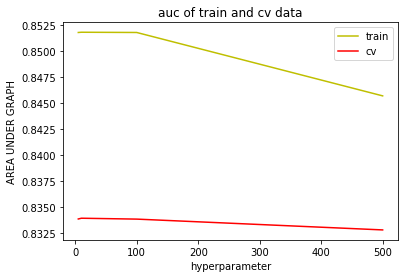

In [46]:
AUCcurve_min(y1=list_train,y2=list_cv)

In [47]:
clf=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=500,
             max_leaf_nodes=1000,
            min_impurity_split=None, min_samples_leaf=100,
            min_samples_split=5, 
            splitter='best')


clf.fit(train_tf_idf, y_train)

pred_test_tf_idf= (clf.predict_proba(test_tf_idf))[:,1]
auc_test=roc_auc_score(y_test,pred_test_tf_idf)*100
print('AUC VALUE FOR TEST DATA',auc_test)
pred_test=clf.predict(test_tf_idf)

AUC VALUE FOR TEST DATA 82.89847500341581


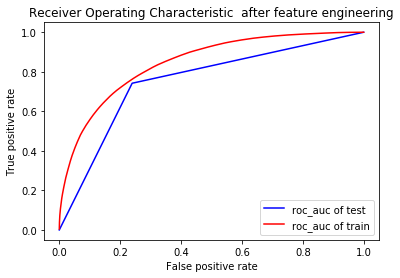

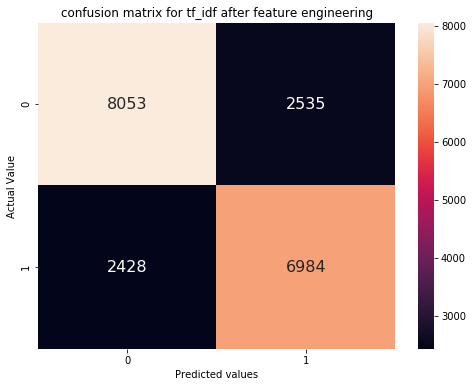

In [48]:

ROC_curve(pred_train,pred_test)
confusion(pred_test)

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [50]:
w=clf.feature_importances_
feature_names=tf_idf_vect.get_feature_names()
top_class=sorted(zip(w,feature_names),reverse=True)[:20]
top_class

[(0.19753977197451333, 'not'),
 (0.13980050625192914, 'great'),
 (0.06813644281946112, 'best'),
 (0.05590625204205192, 'delicious'),
 (0.046725983307281886, 'good'),
 (0.04550517803038894, 'love'),
 (0.03744872473432715, 'perfect'),
 (0.037430468540369057, 'disappointed'),
 (0.030402315720827675, 'loves'),
 (0.02439552110934937, 'bad'),
 (0.021727411583494557, 'excellent'),
 (0.020678449520972482, 'favorite'),
 (0.019979390890694594, 'wonderful'),
 (0.014739627079937234, 'would'),
 (0.014707493535319905, 'nice'),
 (0.013757001921820442, 'not good'),
 (0.01348379379960806, 'thought'),
 (0.012087020750256418, 'highly'),
 (0.011536205976555651, 'tasty'),
 (0.011522178525161892, 'product')]

# [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

In [51]:
import graphviz 
from sklearn.tree import export_graphviz
from sklearn import tree
clf=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3)
clf.fit(train_tf_idf, y_train)

dot_data = tree.export_graphviz(clf, out_file=None,feature_names=tf_idf_vect.get_feature_names()) 
graph = graphviz.Source(dot_data) 

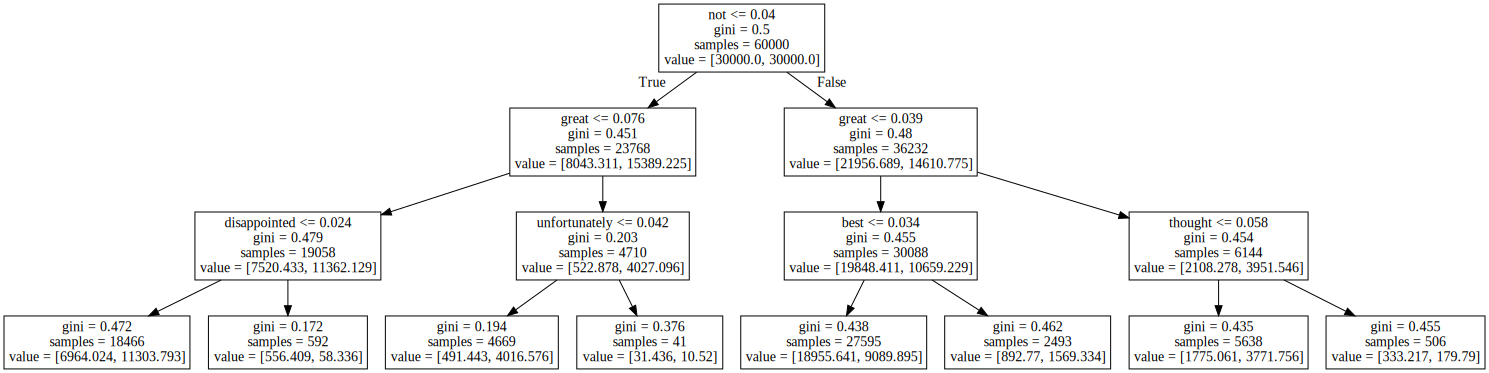

In [52]:
graph

In [411]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/release/bin/'


In [412]:
os.environ["PATH"]

'D:\\python\\DLLs;D:\\python;D:\\python\\Library\\mingw-w64\\bin;D:\\python\\Library\\usr\\bin;D:\\python\\Library\\bin;D:\\python\\Scripts;C:\\Program Files (x86)\\Common Files\\Oracle\\Java\\javapath0.2;C:\\WINDOWS\\system32;C:\\WINDOWS;C:\\WINDOWS\\System32\\Wbem;C:\\WINDOWS\\System32\\WindowsPowerShell\\v1.0\\;C:\\Program Files\\MATLAB\\R2017a\\runtime\\win64;C:\\Program Files\\MATLAB\\R2017a\\bin;C:\\WINDOWS\\System32\\OpenSSH\\;C:\\Program Files\\Java\\jdk-10.0.2\\bin;C:\\Program Files\\Java\\jre-10.0.2\\bin;C:\\Users\\Lenovo\\.pylint.duih;C:\\Users\\Lenovo\\.pylint.duih\\Scripts;C:\\Users\\Lenovo\\.pylint.duih\\Library\\bin;C:\\Users\\Lenovo\\kokl;C:\\Users\\Lenovo\\kokl\\Scripts;C:\\Users\\Lenovo\\kokl\\Library\\bin;D:\\python;D:\\python\\Library\\mingw-w64\\bin;D:\\python\\Library\\usr\\bin;D:\\python\\Library\\bin;D:\\python\\Scripts;C:\\Users\\Lenovo\\AppData\\Local\\Microsoft\\WindowsApps;D:\\m\\miktex\\bin\\x64\\;D:/Program Files (x86)/Graphviz2.38/bin/;D:/Program Files (x

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [222]:
list_train,list_cv,pred_train,pred_cv,depth,clf=SimpleCrossValidation_depth(x_test=sent_vectors_test,x_train=sent_vectors_train,x_cv=sent_vectors_cv,pred_train_data=sent_vectors_train,pred_cv_data=sent_vectors_cv)

AFTER FEATURE ENGINEERING
AUC cv SCORE  FOR 1 is 71.24121714070755
AUC cv SCORE  FOR 5 is 82.01519510169368
AUC cv SCORE  FOR 10 is 84.14721290222823
AUC cv SCORE  FOR 50 is 84.14907529118366
AUC cv SCORE  FOR 100 is 84.14209007490969
AUC cv SCORE  FOR 500 is 84.13370278461659
AUC cv SCORE  FOR 1000 is 84.14438410344476
train AUC SCORE [0.7169784889009823, 0.844506726423075, 0.8872970628545894, 0.8880315903864431, 0.8880315903864431, 0.8880315903864431, 0.8880315903864431]
 MAX CV AUC SCORE 84.14907529118366


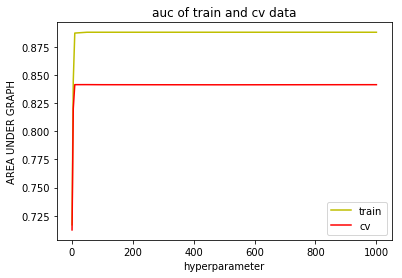

In [223]:
AUCcurve_depth(y1=list_train,y2=list_cv)

In [224]:
list_train,list_cv,pred_train,pred_cv,min,clf=SimpleCrossValidation_min(x_test=sent_vectors_test,x_train=sent_vectors_train,x_cv=sent_vectors_cv,pred_train_data=sent_vectors_train,pred_cv_data=sent_vectors_cv)

AFTER FEATURE ENGINEERING
AUC cv SCORE  FOR 5 is 84.13999325233642
AUC cv SCORE  FOR 10 is 84.13614974838734
AUC cv SCORE  FOR 100 is 84.142392423846
AUC cv SCORE  FOR 500 is 83.65119010377019
train AUC SCORE [0.8880315903864431, 0.8880315903864431, 0.8880315903864431, 0.8700645322115379]
 MAX CV AUC SCORE 84.142392423846


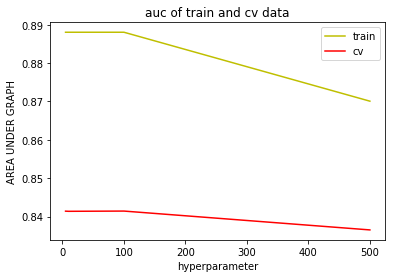

In [225]:
AUCcurve_min(y1=list_train,y2=list_cv)

In [390]:
clf=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=50,
             max_leaf_nodes=1000,
            min_impurity_split=None, min_samples_leaf=100,
            min_samples_split=5, 
            splitter='best')
clf.fit(sent_vectors_train, y_train)

pred_test_sent_vectors= (clf.predict_proba(sent_vectors_test))[:,1]
auc_test=roc_auc_score(y_test,pred_test_sent_vectors)*100
print('AUC VALUE FOR TEST DATA',auc_test)
pred_test=clf.predict(sent_vectors_test)

AUC VALUE FOR TEST DATA 84.14960566357578


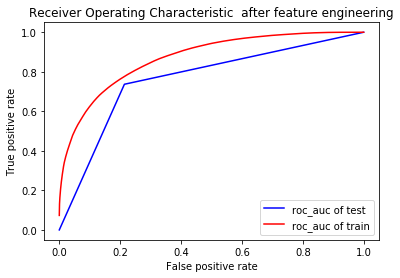

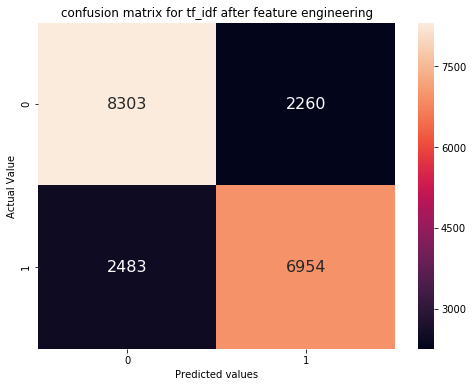

In [231]:

ROC_curve(pred_train,pred_test)
confusion(pred_test)

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [233]:
list_train,list_cv,pred_train,pred_cv,depth,clf=SimpleCrossValidation_depth(x_train=tfidf_sent_vectors_train,
x_cv=tfidf_sent_vectors_cv,pred_train_data=tfidf_sent_vectors_train,pred_cv_data=tfidf_sent_vectors_cv,x_test=tfidf_sent_vectors_test)

AFTER FEATURE ENGINEERING
AUC cv SCORE  FOR 1 is 68.06784219128181
AUC cv SCORE  FOR 5 is 79.28628616862986
AUC cv SCORE  FOR 10 is 81.27384406216271
AUC cv SCORE  FOR 50 is 81.24910125395222
AUC cv SCORE  FOR 100 is 81.24826312861461
AUC cv SCORE  FOR 500 is 81.26628533875495
AUC cv SCORE  FOR 1000 is 81.25531525405421
train AUC SCORE [0.6852575812176247, 0.8143227196198448, 0.864120272417567, 0.8650087382585868, 0.8650087382585868, 0.8650087382585868, 0.8650087382585868]
 MAX CV AUC SCORE 81.27384406216271


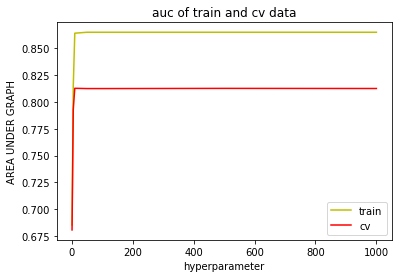

In [234]:
AUCcurve_depth(y1=list_train,y2=list_cv)


In [235]:
list_train,list_cv,pred_train,pred_cv,min,clf=SimpleCrossValidation_min(x_train=tfidf_sent_vectors_train,
x_cv=tfidf_sent_vectors_cv,pred_train_data=tfidf_sent_vectors_train,pred_cv_data=tfidf_sent_vectors_cv,x_test=tfidf_sent_vectors_test)

AFTER FEATURE ENGINEERING
AUC cv SCORE  FOR 5 is 81.24941265826433
AUC cv SCORE  FOR 10 is 81.25683404180582
AUC cv SCORE  FOR 100 is 81.25659357127077
AUC cv SCORE  FOR 500 is 81.03417995865034
train AUC SCORE [0.8650087382585868, 0.8650087382585868, 0.8650087382585868, 0.8430286688195681]
 MAX CV AUC SCORE 81.25683404180582


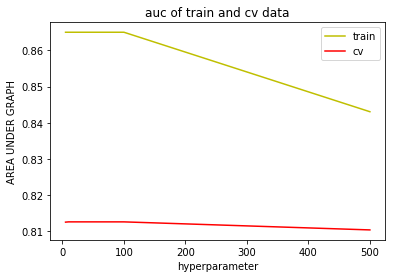

In [236]:
AUCcurve_min(y1=list_train,y2=list_cv)


In [239]:
clf=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=50,
             max_leaf_nodes=1000,
            min_impurity_split=None, min_samples_leaf=100,
            min_samples_split=5, 
            splitter='best')
clf.fit(tfidf_sent_vectors_train, y_train)


pred_test_tf_idf= (clf.predict_proba(tfidf_sent_vectors_test))[:,1]
auc_test=roc_auc_score(y_test,pred_test_tf_idf)*100
print('AUC VALUE FOR TEST DATA',auc_test)
pred_test=clf.predict(tfidf_sent_vectors_test)

AUC VALUE FOR TEST DATA 81.3738754593046


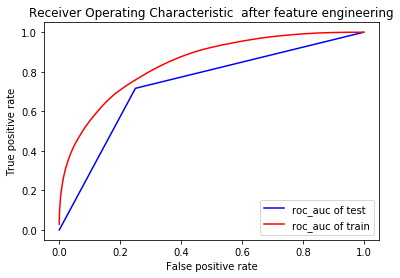

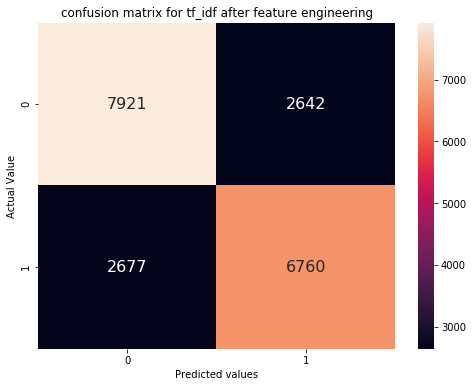

In [240]:
ROC_curve(pred_train,pred_test)
confusion(pred_test)

# [6] Conclusions

In [62]:
# Please compare all your models using Prettytable library
# Please compare all your models using Prettytable library
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer","Model" ,"max_depth","min_sample_split","AUC"]

x.add_row(["BOW", " DecisionTree",1000,10 ,82.83])
x.add_row(["TF-IDF"," DecisionTree",500,5,82.81])
x.add_row(["AVG-W2V"," DecisionTree",50,5,84.14])
x.add_row(["TF-IDF-W2V"," DecisionTree",50,5,81.37])


print(x)

+------------+---------------+-----------+------------------+-------+
| Vectorizer |     Model     | max_depth | min_sample_split |  AUC  |
+------------+---------------+-----------+------------------+-------+
|    BOW     |  DecisionTree |    1000   |        10        | 82.83 |
|   TF-IDF   |  DecisionTree |    500    |        5         | 82.81 |
|  AVG-W2V   |  DecisionTree |     50    |        5         | 84.14 |
| TF-IDF-W2V |  DecisionTree |     50    |        5         | 81.37 |
+------------+---------------+-----------+------------------+-------+
